In [178]:
%matplotlib inline
import matplotlib
from matplotlib import pyplot 
import numpy as np
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16

### Схема HLLC для уравнений Эйлера

In [179]:
gamma = 1.4     #Гамма, она же каппа
#Различные формулы из гаммы
g_m_1_over_2g = (gamma-1)/2/gamma      #g1
g_p_1_over_2g = (gamma+1)/2/gamma      #g2
g_m_1_over_2g_inv = 1/g_m_1_over_2g    #g3
g_m_1_over_2_inv = 2/(gamma-1)         #g4
g_p_1_over_2_inv = 2/(gamma+1)         #g5
g_m_1_over_g_p_1 = (gamma-1)/(gamma+1) #g6
g_m_1_over_2 = (gamma-1)/2             #g7
g_m_1 = gamma-1  

tol = 1e-8

In [180]:
def sound_speed(d,p):
    return (gamma*(p/d))**0.5

In [181]:
def sound_speed_w(W):
    d = W[0]
    p = W[2]
    return sound_speed(d,p) 

In [182]:
def guess_p(W_l,W_r,label):
    c_l = sound_speed(W_l[0],W_l[2])
    c_r = sound_speed(W_r[0],W_r[2])

    
    W_aver = 0.5*(W_l+W_r)
    p_pv = W_aver[2] - 0.5*(W_r[1]-W_l[1])*W_aver[0]*0.5*(c_l+c_r)
    p_0 = max(tol,p_pv)
    
    if label == 'TR':
        return ((c_l + c_r - 0.5*g_m_1*(W_r[1] - W_l[1]))/
                ((c_l/W_l[2]**g_m_1_over_2g) + (c_r/W_r[2]**g_m_1_over_2g) ))**g_m_1_over_2g_inv
    
    elif label == 'PV':

        return p_0
    
    elif label == 'TS':
        A_k = lambda x : g_p_1_over_2_inv/x
        B_k = lambda x : g_m_1_over_g_p_1*x
        p_ts = ((A_k(W_l[0])/(p_pv + B_k(W_l[2])))**0.5*W_l[2] + (A_k(W_r[0])/(p_pv + B_k(W_r[2])))**0.5*W_r[2] \
                - (W_r[1]-W_l[1])) /\
        ((A_k(W_l[0])/(p_pv + B_k(W_l[2])))**0.5 + (A_k(W_r[0])/(p_pv + B_k(W_r[2])))**0.5)  
        return max(tol,p_ts)
    else:
        return W_aver[2]
        
        

In [183]:
def init(case):
    if case == 'sod':
        W_l = np.array([1, 0.75, 1])
        W_r = np.array([0.125, 0, 0.1])
        t = 0.25
    elif case == '123':
        W_l = np.array([1, -2, 0.4])
        W_r = np.array([1, 2, 0.4])
        t = 0.15
    elif case == 'left-woodward':
        W_l = np.array([1, 0, 1000])
        W_r = np.array([1, 0, 0.1])
        
        t = 0.012
    else : print('Unknown case!')
    return W_l, W_r, t

In [184]:
def U_to_W(U):
    W = np.zeros_like(U)
    W[0] = U[0]
    W[1] = U[1]/U[0]
    W[2] = g_m_1*(U[2] - 0.5*U[1]**2/U[0])
    return W

In [185]:
def W_to_U(W):
    U = np.zeros_like(W)
    U[0] = W[0]
    U[1] = W[1]*W[0]
    U[2] = 0.5*W[1]**2*W[0]+W[2]/ g_m_1
    return U


In [186]:
def flux(W):
    F = np.zeros_like(W)
    F[0] = W[1]*W[0]
    F[1] = W[1]**2*W[0] + W[2]
    F[2] = W[1]*(0.5*W[1]**2*W[0]+W[2]/ g_m_1 + W[2])
    return F

In [187]:
def q(p,p_star):
    if p_star > p:
        return (1 + g_p_1_over_2g*(p_star/p - 1))**0.5
    else :
        return 1

In [188]:
def get_speeds_hllc(W_l,W_r,p_star):
    S_l = W_l[1] - sound_speed_w(W_l)*q(W_l[2],p_star)
    S_r = W_r[1] + sound_speed_w(W_r)*q(W_r[2],p_star)
    
    S_star = (W_r[2] - W_l[2] + \
              W_l[0]*W_l[1]*(S_l - W_l[1]) - \
              W_r[0]*W_r[1]*(S_r - W_r[1]))/( W_l[0]*(S_l - W_l[1]) - \
              W_r[0]*(S_r - W_r[1]) )
    return np.asarray((S_l,S_r,S_star))

In [189]:
def get_speeds(W_l,W_r,p_star):
    S_star = max(np.abs(W_l[1])+sound_speed_w(W_l), np.abs(W_r[1])+sound_speed_w(W_r))
    
    S_l = -S_star 
    S_r = S_star
    return np.asarray((S_l,S_r,S_star))

In [190]:
def minmod_kolgan(e, dx):
    sigma = np.zeros_like(e)
    for i in range(1, len(e) - 1):
        de_minus = (e[i] - e[i-1]) / dx
        de_plus = (e[i + 1] - e[i]) / dx
        for j in range(3):
            
            if de_minus[j] > 0 and de_plus[j] > 0:
                sigma[i,j] = min(de_minus[j], de_plus[j])
            elif de_minus[j] < 0 and de_plus[j] < 0:
                sigma[i,j] = max(de_minus[j], de_plus[j])
            else:
                sigma[i,j] = 0.0
    return sigma

In [191]:
def minmod_vanleer(e, dx):
    sigma = np.zeros_like(e)
    for i in range(1, len(e) - 1):
        de_minus = (e[i] - e[i-1]) / dx
        de_plus = (e[i + 1] - e[i]) / dx
        for j in range(3):
            
            if de_minus[j] * de_plus[j] <= 0:
                sigma[i,j] = 0.0
            else:
                sigma[i,j] = 2*de_plus[j]*de_minus[j]/(de_plus[j] + de_minus[j])
    return sigma

In [192]:
def F_HLLC(W,S_star,S):
    D = np.asarray([0,1,S_star])
    F_star = (S_star*(S*W_to_U(W) - flux(W)) + \
              S*(W[2] + W[0]*(S - W[1])*(S_star - W[1]))*D)/\
    (S - S_star)
    return F_star

In [193]:
def hllc_flux(W_l, W_r):
    
    p_star = guess_p(W_l,W_r,'TR')
    S_l,S_r,S_star = get_speeds_hllc(W_l,W_r,p_star)
    if 0 <= S_l:
        return flux(W_l)
    if S_l <= 0 <= S_star:
        return F_HLLC(W_l,S_star,S_l)
    if S_star <= 0 <= S_r:
        return F_HLLC(W_r,S_star,S_r)
    if 0 >= S_r:
        return flux(W_r)

In [194]:
N_points = 101
x = np.linspace(0,1,N_points)
decay_pos = 0.3
W_correct= np.zeros((N_points,3))

%store -r

In [195]:
W_l,W_r,t = init('sod')

In [196]:
#hllc kolgan limitor
dx = 1./(N_points - 1)
sigma = 1

Wc = np.zeros((N_points,3))
Wc[np.where(x<decay_pos),:] = W_l
Wc[np.where(x>=decay_pos),:] = W_r

Uc = np.zeros_like(Wc) 

In [197]:
t_ = 0
#dt = 0.0002
U_n = np.copy(Uc)
U_n_star = np.copy(Uc)

big_values = np.zeros((N_points - 1,3))
speeds = np.zeros(N_points - 1)
hllc_fluxes = np.zeros((N_points - 1,3))

while t_<t:
    Uc = W_to_U(Wc.T).T
    speeds = np.zeros(N_points - 1)
    
    grads = minmod_kolgan(Wc,dx)
    W_l = (Wc + grads * dx / 2.0)[:-1]
    W_r = (Wc - grads * dx / 2.0)[1:]
        
    for i,x_ in enumerate(x[:-1]):
        hllc_fluxes[i] =hllc_flux(W_l[i], W_r[i])
        
        c_l = sound_speed(W_l[i][0],W_l[i][2])
        c_r = sound_speed(W_r[i][0],W_r[i][2])
        speeds[i] = max(abs(W_l[i][1])+c_l,abs(W_r[i][1])+  c_r)

    dt = sigma*dx/max(speeds)
    U_n_star[1:-1,:] = Uc[1:-1,:] + dt/dx*(hllc_fluxes[:-1,:]-hllc_fluxes[1:,:]) 
    U_n_star[0,:] = U_n_star[1,:]
    U_n_star[-1,:] = U_n_star[-2,:]
    
    W_star = U_to_W(U_n_star.T).T
    grads = minmod_kolgan(W_star,dx)
    W_l = (W_star + grads * dx / 2.0)[:-1]
    W_r = (W_star - grads * dx / 2.0)[1:]
    
    for i,x_ in enumerate(x[:-1]):
        hllc_fluxes[i] = hllc_flux(W_l[i],W_r[i])

    U_n[1:-1,:] = 0.5*(Uc[1:-1,:] + U_n_star[1:-1,:] + dt/dx*(hllc_fluxes[:-1,:]-hllc_fluxes[1:,:]))
    U_n[0,:] = U_n[1,:]
    U_n[-1,:] = U_n[-2,:]
    
    Wc = U_to_W(U_n.T).T
    t_=t_+dt

In [198]:
W_l,W_r,t = init('sod')

In [199]:
#hllc vanleer limitor
dx = 1./(N_points - 1)
sigma = 1

Wv = np.zeros((N_points,3))
Wv[np.where(x<decay_pos),:] = W_l
Wv[np.where(x>=decay_pos),:] = W_r

Uv = np.zeros_like(Wv) 

In [200]:
t_ = 0
#dt = 0.0002
U_n = np.copy(Uv)
U_n_star = np.copy(Uv)

big_values = np.zeros((N_points - 1,3))
speeds = np.zeros(N_points - 1)
hllc_fluxes = np.zeros((N_points - 1,3))

while t_<t:
    Uv = W_to_U(Wv.T).T
    speeds = np.zeros(N_points - 1)
    
    grads = minmod_vanleer(Wv,dx)
    W_l = (Wv + grads * dx / 2.0)[:-1]
    W_r = (Wv - grads * dx / 2.0)[1:]
    
    for i,x_ in enumerate(x[:-1]):
        hllc_fluxes[i] =hllc_flux(W_l[i], W_r[i])
        c_l = sound_speed(W_l[i][0],W_l[i][2])
        c_r = sound_speed(W_r[i][0],W_r[i][2])
        speeds[i] = max(abs(W_l[i][1])+c_l,abs(W_r[i][1])+  c_r)

    dt = sigma*dx/max(speeds)
    U_n_star[1:-1,:] = Uv[1:-1,:] + dt/dx*(hllc_fluxes[:-1,:]-hllc_fluxes[1:,:]) 
    U_n_star[0,:] = U_n_star[1,:]
    U_n_star[-1,:] = U_n_star[-2,:]
    
    W_star = U_to_W(U_n_star.T).T
    grads = minmod_vanleer(W_star,dx)
    W_l = (W_star + grads * dx / 2.0)[:-1]
    W_r = (W_star - grads * dx / 2.0)[1:]
    
    for i,x_ in enumerate(x[:-1]):
        hllc_fluxes[i] = hllc_flux(W_l[i],W_r[i])

    U_n[1:-1,:] = 0.5*(Uv[1:-1,:] + U_n_star[1:-1,:] + dt/dx*(hllc_fluxes[:-1,:]-hllc_fluxes[1:,:]))
    U_n[0,:] = U_n[1,:]
    U_n[-1,:] = U_n[-2,:]
    
    Wv = U_to_W(U_n.T).T
    t_=t_+dt

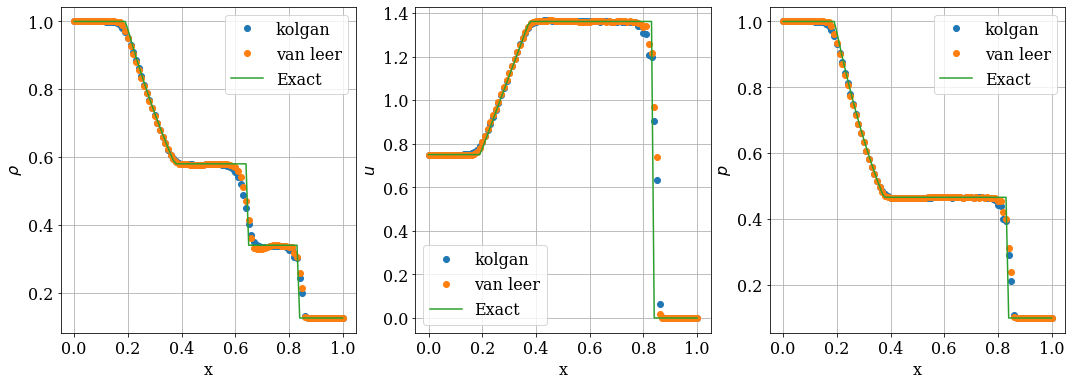

In [201]:
fig,axs = pyplot.subplots(1,3,figsize=(18,6)
                         )
for ax, Wc_, Wv_, W_c, y_label in zip(axs, Wc.T, Wv.T, W_correct.T, (r'$\rho$',r'$u$',r'$p$') ):
    ax.plot(x,Wc_,'o',label='kolgan')
    ax.plot(x, Wv_, 'o', label='van leer')
    ax.plot(x,W_c,label='Exact')
    ax.set_ylabel(y_label)
    ax.set_xlabel('x')
    scale_y = 1.1*abs(max(W_c)-min(W_c))
    ax.set_ylim(0.5*(max(W_c)+min(W_c) - scale_y), 0.5*(max(W_c)+min(W_c) + scale_y))
    ax.legend(loc='best')
    ax.grid()